In [202]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.api as stats
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
# from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv("../data/train.csv",sep=",")
validate = pd.read_csv("../data/validate.csv",sep=",")
test = pd.read_csv("../data/test.csv",sep=",")

In [5]:
#Drop an extraneous column and determine the shape of the train data frame.
train=train.drop(['Unnamed: 0'], axis=1)
test=test.drop(['Unnamed: 0'], axis=1)
validate=validate.drop(['Unnamed: 0'], axis=1)
train.shape

(5174, 68)

In [6]:
pd.set_option("display.max_columns", None)
train.head()

,Attrition,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked_Missing,TotalWorkngYears_Missing,EnvironmentSatisfaction_Missing,JobSatisfaction_Missing,WorkLifeBalance_Missing,Age_Bin,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Education_2,Education_3,Education_4,Education_5,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,MaritalStatus_Married,MaritalStatus_Single,Department_Research_Development,Department_Sales,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,Age_sd,DistanceFromHome_sd,MonthlyIncome_sd,NumCompaniesWorked_sd,PercentSalaryHike_sd,TotalWorkingYears_sd,TrainingTimesLastYear_sd,YearsAtCompany_sd,YearsSinceLastPromotion_sd,YearsWithCurrManager_sd,PerformanceRating_sd,JobInvolvement_sd,EnvironmentSatisfaction_sd,JobSatisfaction_sd,WorkLifeBalance_sd
0,0,30,1,174260,2.0,14,12.0,0,10,7,4,3,4,2.0,4.0,2.0,1,1,1,1,1,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-0.758170,-0.976699,2.320919,-0.278689,-0.089744,0.092632,-2.171982,0.488508,1.493867,-0.034520,0.048254,1.130348,-0.893425,0.960986,-1.113344
1,0,20,14,84120,1.0,13,2.0,2,2,2,2,3,4,3.0,2.0,4.0,1,1,1,1,1,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,-1.853188,0.847690,0.405636,-0.679777,-0.329606,-1.193808,-0.620189,-0.817734,-0.058285,-0.595227,0.048254,1.130348,0.049910,-1.150490,1.077889
2,0,53,11,35170,2.0,19,13.0,1,7,4,5,3,4,4.0,4.0,2.0,1,1,1,1,1,3.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1.760373,0.426677,-0.634447,-0.278689,1.109565,0.221276,-1.396086,-0.001333,0.562576,0.245834,0.048254,1.130348,0.993244,0.960986,-1.113344
3,0,29,18,79690,0.0,14,6.0,3,5,1,3,3,3,3.0,4.0,4.0,1,1,1,1,1,0.0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,-0.867672,1.409040,0.311508,-1.080866,-0.089744,-0.679232,0.155707,-0.327893,-0.368715,-0.314873,0.048254,-0.031347,0.049910,0.960986,1.077889
4,0,26,2,139640,1.0,11,5.0,1,5,1,3,3,2,3.0,4.0,4.0,1,1,1,1,1,0.0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,-1.196177,-0.836361,1.585318,-0.679777,-0.809330,-0.807876,-1.396086,-0.327893,-0.368715,-0.314873,0.048254,-1.193043,0.049910,0.960986,1.077889


In [7]:
#Drop missing values (Limitation)
train.dropna(inplace=True)

X_train = train.iloc[:,16:]

y_train = train['Attrition']

## Feature Selection / Dimensionality Reduction

### Variance threshold


In [13]:
# Removes all features whose variance doesn’t meet some threshold
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X_train)
sel.get_feature_names_out()

array(['Age_Bin', 'Gender_Male', 'BusinessTravel_Travel_Rarely',
       'Education_3', 'Education_4', 'EducationField_Life_Sciences',
       'EducationField_Medical', 'JobLevel_2', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Department_Research_Development',
       'Department_Sales', 'StockOptionLevel_1', 'Age_sd',
       'DistanceFromHome_sd', 'MonthlyIncome_sd', 'NumCompaniesWorked_sd',
       'PercentSalaryHike_sd', 'TotalWorkingYears_sd',
       'TrainingTimesLastYear_sd', 'YearsAtCompany_sd',
       'YearsSinceLastPromotion_sd', 'YearsWithCurrManager_sd',
       'PerformanceRating_sd', 'JobInvolvement_sd',
       'EnvironmentSatisfaction_sd', 'JobSatisfaction_sd',
       'WorkLifeBalance_sd'], dtype=object)

In [18]:
X_train['Age_sd'].mean()

-0.10918236239955988

In [19]:
SEED = 42

#### Filter selction method (Univariate feature selection based on mutual info)


In [57]:
from sklearn.feature_selection import mutual_info_classif


# Use SelectKBest to select the top 10 features
info = mutual_info_classif(X_train,y_train, random_state = SEED)
K = 10
print(np.sort(info.round(2))[-K:])
k_best_idx = np.argsort(info.round(2))[-K:]
np.array((X_train.columns[k_best_idx]))



[0.14 0.15 0.2  0.26 0.29 0.3  0.35 0.38 0.4  0.44]


array(['YearsWithCurrManager_sd', 'Age_sd', 'DistanceFromHome_sd',
       'EnvironmentSatisfaction_sd', 'JobSatisfaction_sd',
       'JobInvolvement_sd', 'PerformanceRating_sd', 'WorkLifeBalance_sd',
       'MonthlyIncome_sd', 'PercentSalaryHike_sd'], dtype=object)

### Recursive feature elimination

In [81]:
# Create a logistic regression model
model = LogisticRegression(random_state = SEED, max_iter = 1000)

# Use RFE to select the top 10 features
rfe = RFE(
    estimator = model,
    step =0.1,
    n_features_to_select=10)
rfe.fit(X_train, y_train)

# Print the selected features

RFE(estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_features_to_select=10, step=0.1)

In [82]:
rfe.get_feature_names_out()

array(['WorkLifeBalance_Missing', 'Education_5',
       'EducationField_Life_Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical_Degree', 'PerformanceRating_sd',
       'JobInvolvement_sd', 'WorkLifeBalance_sd'], dtype=object)

### Recursive feature elimination with cross validation

In [67]:
# Create a logistic regression model
model = LogisticRegression(random_state = SEED, max_iter = 1000)
# cv = StratifiedKFold(5)

# Use RFE to select the top 10 features
rfecv = RFECV(
    estimator = model,
    step =0.1,
    cv = cv,
    scoring = 'f1',
    min_features_to_select=10,
    n_jobs = -1)
rfecv.fit(X_train, y_train)





RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(max_iter=1000, random_state=42),
      min_features_to_select=10, n_jobs=-1, scoring='f1', step=0.1)

In [68]:
# print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 47


In [196]:
cols = list(X_train.loc[:,rfecv.support_].columns)

In [84]:
np.intersect1d(sel.get_feature_names_out(), np.array((X_train.columns[k_best_idx])))


array(['Age_sd', 'DistanceFromHome_sd', 'EnvironmentSatisfaction_sd',
       'JobInvolvement_sd', 'JobSatisfaction_sd', 'MonthlyIncome_sd',
       'PercentSalaryHike_sd', 'PerformanceRating_sd',
       'WorkLifeBalance_sd', 'YearsWithCurrManager_sd'], dtype=object)

## Models

In [208]:
def get_OR(model):

    # Build a data frame with odds ratios and their confidence intervals.
    odds_ratios = pd.DataFrame(
        {
            "OR": model.params,
            "Lower CI": model.conf_int()[0],
            "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the results
    # print(odds_ratios.sort_values('OR'))

    return (odds_ratios.sort_values('OR').round(3))


def get_prob(model):

    # Build a data frame with odds ratios and their confidence intervals.
    odds_ratios = pd.DataFrame(
        {
            "Prob": model.params,
            "Lower CI": model.conf_int()[0],
            "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    probabilities = odds_ratios / (1+odds_ratios)

    return (probabilities.sort_values('Prob').round(3))


### Create intercept only model

In [147]:
log_reg_base = sm.logit("Attrition ~ 1", data=train).fit()
print(log_reg_base.summary())

Optimization terminated successfully.
         Current function value: 0.665593
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4194
Model:                          Logit   Df Residuals:                     4193
Method:                           MLE   Df Model:                            0
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:               4.119e-12
Time:                        16:37:42   Log-Likelihood:                -2791.5
converged:                       True   LL-Null:                       -2791.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4761      0.032    -14.991      0.000      -0.538      -0.414


In [148]:
get_OR(log_reg_base)

,OR,Lower CI,Upper CI
Intercept,0.621,0.584,0.661


In [209]:
get_prob(log_reg_base)

,Prob,Lower CI,Upper CI
Intercept,0.383,0.369,0.398


### Create baseline model based on Initiative Options

In [150]:
log_reg = sm.logit("Attrition ~ MonthlyIncome_sd + TrainingTimesLastYear_sd + EnvironmentSatisfaction_sd + WorkLifeBalance_sd + JobSatisfaction_sd", data=train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.336615
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4194
Model:                          Logit   Df Residuals:                     4188
Method:                           MLE   Df Model:                            5
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                  0.4943
Time:                        16:37:43   Log-Likelihood:                -1411.8
converged:                       True   LL-Null:                       -2791.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.8545      0.068    -27.442      0.000      

In [151]:
get_OR(log_reg)

,OR,Lower CI,Upper CI
Intercept,0.157,0.137,0.179
WorkLifeBalance_sd,0.165,0.147,0.186
JobSatisfaction_sd,0.414,0.374,0.458
EnvironmentSatisfaction_sd,0.452,0.409,0.500
TrainingTimesLastYear_sd,0.846,0.766,0.933
MonthlyIncome_sd,0.965,0.877,1.062


In [152]:
get_prob(log_reg)

,Prob,Lower CI,Upper CI
Intercept,0.135,0.121,0.152
WorkLifeBalance_sd,0.142,0.128,0.156
JobSatisfaction_sd,0.293,0.272,0.314
EnvironmentSatisfaction_sd,0.311,0.290,0.333
TrainingTimesLastYear_sd,0.458,0.434,0.483
MonthlyIncome_sd,0.491,0.467,0.515


In [153]:
# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
print(odds_ratios.sort_values('OR'))

                                  OR  Lower CI  Upper CI
Intercept                   0.156537  0.137118  0.178707
WorkLifeBalance_sd          0.164903  0.146578  0.185517
JobSatisfaction_sd          0.413775  0.374137  0.457612
EnvironmentSatisfaction_sd  0.452071  0.408995  0.499684
TrainingTimesLastYear_sd    0.845509  0.766014  0.933254
MonthlyIncome_sd            0.964811  0.876831  1.061619


### Asess Collinaearity

In [213]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif_data = X_train.assign(const=1)  # Add constant column for intercept

vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

vif.sort_values(by = 'VIF', ascending = False)

,Variable,VIF
52,const,718.190559
37,Age_sd,12.064917
5,Age_Bin,10.588077
21,EducationField_Life_Sciences,6.099204
23,EducationField_Medical,5.593941
33,Department_Sales,4.967523
32,Department_Research_Development,4.711313
44,YearsAtCompany_sd,4.085380
22,EducationField_Marketing,3.733370
42,TotalWorkingYears_sd,3.301216


### Extend model: Add potential confounders (based on correlation coefficients (notebook 1) and sklearn feature selection process)

In [214]:
# log_reg_ext = sm.logit("Attrition ~ MonthlyIncome_sd + TrainingTimesLastYear_sd + EnvironmentSatisfaction_sd + WorkLifeBalance_sd + \
#                         JobSatisfaction_sd+ PercentSalaryHike_sd + TotalWorkingYears_sd + YearsWithCurrManager_sd + YearsAtCompany_sd +\
#                        Age_sd + DistanceFromHome_sd + PerformanceRating_sd	+ JobInvolvement_sd ", data=train).fit()

log_reg_ext = sm.logit("Attrition ~ MonthlyIncome_sd + TrainingTimesLastYear_sd + EnvironmentSatisfaction_sd + WorkLifeBalance_sd + \
                        JobSatisfaction_sd+ PercentSalaryHike_sd + YearsWithCurrManager_sd +\
                       DistanceFromHome_sd + PerformanceRating_sd + JobInvolvement_sd ", data=train).fit()

print(log_reg_ext.summary())

Optimization terminated successfully.
         Current function value: 0.167630
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4194
Model:                          Logit   Df Residuals:                     4183
Method:                           MLE   Df Model:                           10
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                  0.7481
Time:                        18:56:09   Log-Likelihood:                -703.04
converged:                       True   LL-Null:                       -2791.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.2538      0.127    -25.536      0.000      

In [155]:
get_OR(log_reg_ext)

,OR,Lower CI,Upper CI
Intercept,0.037,0.029,0.048
WorkLifeBalance_sd,0.169,0.143,0.200
JobInvolvement_sd,0.252,0.214,0.296
PerformanceRating_sd,0.312,0.265,0.367
JobSatisfaction_sd,0.397,0.343,0.458
PercentSalaryHike_sd,0.433,0.364,0.514
EnvironmentSatisfaction_sd,0.474,0.410,0.548
Age_sd,0.633,0.544,0.738
YearsWithCurrManager_sd,0.665,0.524,0.844
TrainingTimesLastYear_sd,0.695,0.592,0.816


### Calculate change in odds

In [229]:
(get_OR(log_reg_ext) - 1) * 100

,OR,Lower CI,Upper CI
Intercept,-96.1,-97.0,-95.0
WorkLifeBalance_sd,-83.3,-85.8,-80.3
JobInvolvement_sd,-74.2,-78.0,-69.7
PerformanceRating_sd,-69.5,-74.0,-64.1
JobSatisfaction_sd,-60.7,-65.9,-54.7
PercentSalaryHike_sd,-56.5,-63.3,-48.4
EnvironmentSatisfaction_sd,-51.8,-58.2,-44.4
YearsWithCurrManager_sd,-37.2,-46.0,-26.9
TrainingTimesLastYear_sd,-26.0,-36.6,-13.7
MonthlyIncome_sd,1.0,-11.8,15.6


This means that each additional increase (standard deviation) of one WorkLifeBalance_sd is associated with an 83.3% decrease in the odds of a worker leaving the company.

Other highly related

In [226]:
# get_prob(log_reg_ext)

## Predictions on Extended Model (test_data)

In [183]:
log_reg_ext.pred_table()

array([[2469.,  118.],
       [ 141., 1466.]])

In [179]:
# Building a confusion matrix on the test dataset

y_pred = log_reg_ext.predict(test)

# Y-pred are the probabilities that each row (employee) in the test set will attrite.
# To produce a confusion matrix work we need to change that those probabilities to binary (0,1) values.
# This can be done by rounding the y_pred values
prediction = list(map(round, y_pred))

/opt/homebrew/Caskroom/miniforge/base/envs/acme/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


[]

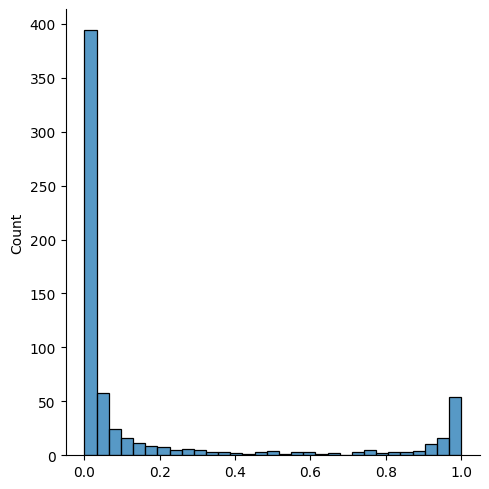

In [224]:
# sns.displot(y_pred, kde=False, rug=False)
sns.displot(y_pred, kde=False, rug=False)
plt.plot()

In [184]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], prediction)
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], prediction))

Confusion Matrix : 
 [[538  23]
 [ 11  90]]
Test accuracy =  0.9486404833836858


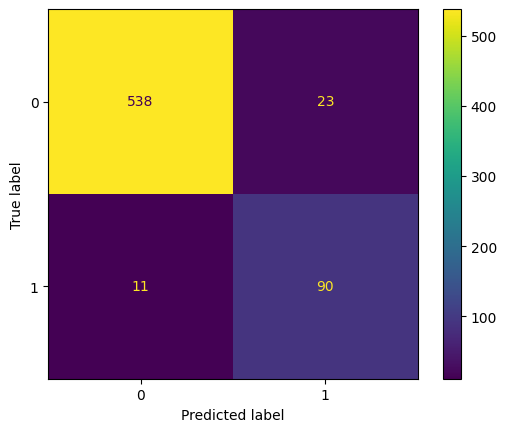

In [185]:
# Should we want a slightly more graphical display, sklearn also offers ConfusionMatrixDisplay()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [186]:
# Classification_report() has two required fields: the ground truth (y) and the binary predicted values (pred)

print(classification_report(test['Attrition'],prediction))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       561
           1       0.80      0.89      0.84       101

    accuracy                           0.95       662
   macro avg       0.89      0.93      0.91       662
weighted avg       0.95      0.95      0.95       662



In [187]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model. 
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

auc=roc_auc_score(test['Attrition'],y_pred )
print(auc)

0.9838689751328074


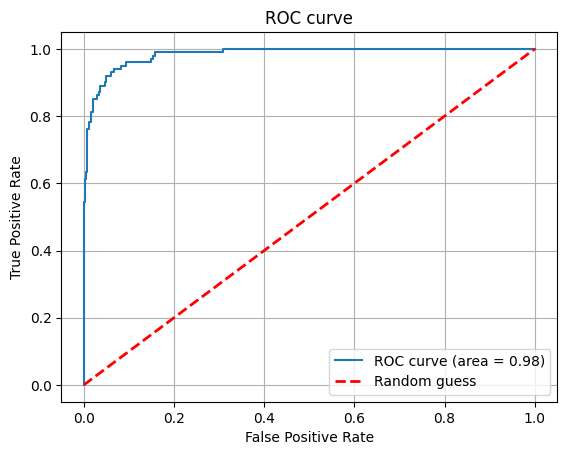

In [188]:
# Use Scikit-learn's ROC Curve Utility to plot ROC curve. For reference, we also include a 'line of determination (y=x)',
# which represents no lift from the model (just random guessing, the worst kind of model performance).
# Our goal is to produce a model that separates from the line of determination and captures as much of the area above the line
# as possible.

fpr, tpr, thresholds = roc_curve(test['Attrition'],  y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()

## What savings in employee acquisition/training could this initiative generate?

In [312]:
# Use test model data

# Average probability of attrition in the test data
mean_prob_test = y_pred.mean().round(2)
mean_prob_test

0.19

In [314]:
# Add change in initiative variable while controlling for others

log_reg_ext.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 4194
Model:                          Logit   Df Residuals:                     4183
Method:                           MLE   Df Model:                           10
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                  0.7481
Time:                        18:07:41   Log-Likelihood:                -703.04
converged:                       True   LL-Null:                       -2791.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.2538      0.127    -25.536      0.000      -3.504      -3.004
MonthlyIncome_sd               0.0100      0.069      0.145      0.885      -0.125       0.145
TrainingTimesLastYear_sd      -0.3016      0.079     -3.820      0.000      -0.456      -0.147
EnvironmentSatisfaction_sd    -0.7303      0.073    -10.043      0.000      -0.873      -0.588
WorkLifeBalance_sd            -1.7894      0.084    -21.244      0.000      -1.954      -1.624
JobSatisfaction_sd            -0.9339      0.073    -12.880      0.000      -1.076      -0.792
PercentSalaryHike_sd          -0.8318      0.086     -9.619      0.000      -1.001      -0.662
YearsWithCurrManager_sd       -0.4650      0.077     -6.024      0.000      -0.616      -0.314
DistanceFromHome_sd            0.5205      0.070      7.485      0.000       0.384       0.657
PerformanceRating_sd          -1.1859      0.082    -14.512      0.000      -1.346      -1.026
JobInvolvement_sd             -1.3539      0.081    -16.639      0.000      -1.513      -1.194
==============================================================================================
"""

## Come back to this

In [285]:
from sklearn.preprocessing import StandardScaler

# First Standarize variable to be chnaged, and get mean and standard devation values
df = pd.read_csv("../data/df.csv",sep=",") # Load cleaned dataframe


scaler =  StandardScaler().fit(df[['TrainingTimesLastYear', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobSatisfaction']])

means = scaler.mean_
deviations = scaler.var_

# print(means, deviations)

In [303]:
X = df[['MonthlyIncome_sd', 'TrainingTimesLastYear_sd', 'EnvironmentSatisfaction_sd', 'WorkLifeBalance_sd', 'JobSatisfaction_sd',
    'PercentSalaryHike_sd', 'YearsWithCurrManager_sd' ,'DistanceFromHome_sd', 'PerformanceRating_sd', 'JobInvolvement_sd']].copy()

X['Intercept'] = 1

y = df['Attrition']

# Log odds of the average case

model = stats.Logit(y, X).fit()

# # Calculate the mean values for the input variables
# mean_values = X.mean()

# # Make a prediction using the mean values
# predicted_log_odds = model.predict(mean_values)

# # # Extract the confidence interval
# # conf_interval = predicted_log_odds.conf_int()

# y = intercept (all other values are multiplied by 0)

log_odds = model.params['Intercept'] # Mean of all other scaled values is 0, so all that is left is the intercept

print("Predicted Log Odds:", log_odds)

OR = np.exp(log_odds)

print("Predicted Odds Ratio:", OR)

probability = OR / (1+OR)

print("Predicted Probability of Attrition:" ,probability*100)



Optimization terminated successfully.
         Current function value: 0.126183
         Iterations 9
Predicted Log Odds: -4.143759350877424
Predicted Odds Ratio: 0.015863104294466225
Predicted Probability of Attrition: 1.5615395644754138


In [305]:
# Plug in value to stardized formula
# | standardized_value = (value - mean) / standard_deviation
# |# y = intercept + coef*variable_std


# Effect of increase work_life by 0.3
variable = 2
work_life_option = 0.3 - means[variable] / deviations[variable]
work_life_option

# new_X_mean = X.mean().copy()
# new_X_mean['WorkLifeBalance_sd'] = work_life_option

# # Make a prediction using the mean values
# new_predicted_log_odds = model.predict(new_X_mean)

# # Extract the confidence interval
# conf_interval = predicted_log_odds.conf_int()

print("Predicted Log Odds:", new_predicted_log_odds.values)

New_OR = np.exp(new_predicted_log_odds.values)

print("Predicted Odds Ratio:", New_OR)

New_prob = New_OR / (1+New_OR)

print("Predicted Probability of Attrition:" ,New_prob)




Predicted Log Odds: [0.74988612]
Predicted Odds Ratio: [2.11675895]
Predicted Probability of Attrition: [0.67915388]


In [ ]:
# Interpret the change in numbers of employees and total costs